In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#read the input drug-metabolite data
data = pd.read_csv('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\data\\Gemcitabine_metabolic_NCI.csv')
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-[6-deoxy-a-L-galactopyranosyl-(1->4)]-O-b-D-galactopyranosyl-(1->4)-O-[6-deoxy-a-L-galactopyranosyl-(1->3)]-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso6] ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso3]","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),cells,Cell names,Gemcitabine
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,0.036367,0.025836,0.075427,0.036502,0.019935,0.032820,0.039391,BT549,BR:BT-549,4.794
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,0.024981,0.013982,0.054200,0.029125,0.010750,0.015981,0.035154,HS578T,BR:HS 578T,5.600


In [4]:
#drop the target drug column
drug = data.pop('Gemcitabine')

In [5]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()

In [6]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')
X = X[rep_meta]
#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [7]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [8]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [9]:
X.shape, y.shape

((52, 197), (52,))

In [10]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    27
1    25
dtype: int64

In [11]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [12]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,1.421446,-0.155943,-0.820807,-0.764873,0.176513,-0.592751,0.217048,-0.421514,-0.398037,0.67937,...,-1.085346,-0.986766,-0.334583,-1.112364,0.841049,-1.204004,-0.369824,0.356009,-0.669323,1.114645
1,-0.276533,0.572536,-0.474419,-0.160824,0.726806,-0.304058,-1.106525,-1.011080,-1.062693,1.19591,...,-0.705743,-0.193225,-1.073172,0.019150,-0.860808,-1.068167,-1.023607,-2.011757,-1.531648,0.751141


In [13]:
X.shape, y.shape

((54, 197), (54,))

In [14]:
y.value_counts()

1    27
0    27
dtype: int64

In [15]:
X.shape

(54, 197)

In [16]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [17]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features 
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    

    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 78
Number of features selected during iteration 1: 69
Number of features selected during iteration 2: 74
Number of features selected during iteration 3: 74
Number of features selected during iteration 4: 62
Number of features selected during iteration 5: 80
Number of features selected during iteration 6: 75
Number of features selected during iteration 7: 74
Number of features selected during iteration 8: 76
Number of features selected during iteration 9: 76
Number of features selected during iteration 10: 75
Number of features selected during iteration 11: 68
Number of features selected during iteration 12: 70
Number of features selected during iteration 13: 73
Number of features selected during iteration 14: 74
Number of features selected during iteration 15: 73
Number of features selected during iteration 16: 73
Number of features selected during iteration 17: 74
Number of features selected during iteration 18: 71
Number of features sel

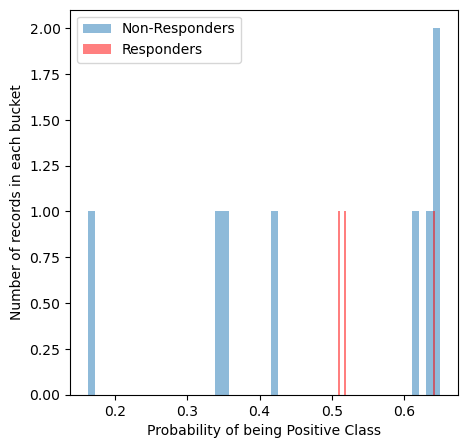

In [18]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5, bins = 50)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [19]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [20]:
df1

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.421446,-0.155943,-0.820807,-0.764873,0.176513,-0.592751,0.217048,-0.421514,-0.398037,0.679370,...,-0.334583,-1.112364,0.841049,-1.204004,-0.369824,0.356009,-0.669323,1.114645,NaN,NaN
1,-0.276533,0.572536,-0.474419,-0.160824,0.726806,-0.304058,-1.106525,-1.011080,-1.062693,1.195910,...,-1.073172,0.019150,-0.860808,-1.068167,-1.023607,-2.011757,-1.531648,0.751141,NaN,NaN
2,0.917049,0.895743,-1.111086,-0.418279,0.670938,-0.708936,0.749646,0.704073,0.669361,-0.581583,...,0.109263,-0.975546,-0.100293,-1.093242,-0.235740,-0.480951,-0.557013,-0.180528,NaN,NaN
3,-1.404404,-1.398709,0.840344,0.805608,1.267643,-0.486297,0.309795,1.693589,1.809365,-0.688164,...,-0.063484,-0.269385,0.365588,0.180347,-0.321133,-0.747372,0.579028,-0.752884,NaN,NaN
4,-1.428276,-0.030653,-0.487401,0.307332,-1.303769,-0.704605,-0.787556,-0.148086,-0.509767,-0.818812,...,-1.162260,0.264939,-1.561619,1.072908,-1.897890,-0.590766,-1.063269,-0.034932,NaN,NaN
5,-0.122632,-0.030653,-0.658222,-0.149505,0.047454,-0.376167,1.183834,0.809655,0.484157,1.631954,...,-0.354849,0.492494,0.097928,0.637338,-1.299829,1.089749,0.615303,-1.007477,0.162533,0.0
6,-0.028387,-1.600535,-0.274027,0.442857,-0.476422,-0.138457,-1.200257,-0.624682,-0.779818,0.094471,...,-0.526166,-0.860416,-0.339996,0.180957,0.165533,-0.772022,-0.394404,1.738498,0.645733,0.0
7,-1.993223,-0.030653,0.328400,0.027379,-0.028674,-0.239473,-0.672452,-1.200074,-1.390005,1.567773,...,-1.997326,-0.735551,-2.008697,0.757392,-1.504734,-1.184572,-0.980471,-1.347526,NaN,NaN
8,-0.830990,-0.429200,-0.831757,-1.207008,0.666399,-0.794150,0.111326,1.295991,1.658446,-0.293185,...,0.266737,-1.034167,-0.020598,-0.813857,-0.372621,0.084995,0.243565,0.066779,NaN,NaN
9,2.406220,-1.138422,-0.060254,0.598620,0.306704,-0.587151,0.235557,0.175742,0.240367,0.233553,...,0.107424,-1.045998,0.595314,-0.177065,0.421267,0.056379,0.238078,0.619778,NaN,NaN


In [21]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(0, 199)

In [22]:
x

0.6496000000000004

In [23]:
df1_main.index.values #0 40 41 42

array([], dtype=int64)

In [24]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features
num_features2 = []

#define the model
model2 = SVC(C=1, gamma=1, probability=True)

#define a list to store accuracy, precision and recall 
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))

    #store the probabilities of each run
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 79
Features selected during iteration 1: 72
Features selected during iteration 2: 77
Features selected during iteration 3: 71
Features selected during iteration 4: 69
Features selected during iteration 5: 63
Features selected during iteration 6: 72
Features selected during iteration 7: 74
Features selected during iteration 8: 80
Features selected during iteration 9: 71
Features selected during iteration 10: 73
Features selected during iteration 11: 80
Features selected during iteration 12: 72
Features selected during iteration 13: 71
Features selected during iteration 14: 69
Features selected during iteration 15: 72
Features selected during iteration 16: 75
Features selected during iteration 17: 70
Features selected during iteration 18: 83
Features selected during iteration 19: 73
Features selected during iteration 20: 69
Features selected during iteration 21: 73
Features selected during iteration 22: 77
Features selected during iteration 23: 69
Fe

In [25]:
print(np.mean(num_features2))

73.24


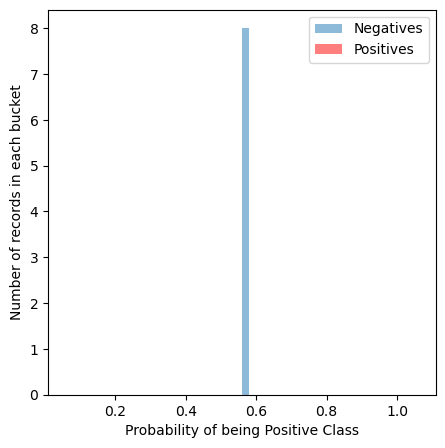

In [26]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [27]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [28]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
13,-0.410634,0.288067,-0.553206,2.475739,0.002499,-0.371078,-0.961989,0.007428,-0.203719,0.121336,...,0.780801,0.941834,0.203433,-0.099921,1.316756,0.057736,0.406860,-0.845098,0.559503,1.0
19,1.502590,-1.718961,-1.208068,-0.870104,0.268140,-1.148039,0.193726,0.542698,0.748482,-1.229169,...,0.020257,-1.034559,-0.336676,-1.053117,-0.276233,-0.060669,-0.441173,0.772968,0.559503,1.0


In [29]:
max(prediction2[y_test == 0])

0.559503286802833

In [30]:
df2_main.index.values #40 41 42

array([13, 19], dtype=int64)

In [31]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features selected in each iteration
num_features3 = []

#define the model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 19
Features selected during iteration 1: 19
Features selected during iteration 2: 19
Features selected during iteration 3: 19
Features selected during iteration 4: 19
Features selected during iteration 5: 19
Features selected during iteration 6: 19
Features selected during iteration 7: 19
Features selected during iteration 8: 19
Features selected during iteration 9: 19
Features selected during iteration 10: 19
Features selected during iteration 11: 19
Features selected during iteration 12: 19
Features selected during iteration 13: 19
Features selected during iteration 14: 19
Features selected during iteration 15: 19
Features selected during iteration 16: 19
Features selected during iteration 17: 19
Features selected during iteration 18: 19
Features selected during iteration 19: 19
Features selected during iteration 20: 19
Features selected during iteration 21: 19
Features selected during iteration 22: 19
Features selected during iteration 23: 19
Fe

In [32]:
print(np.mean(num_features3))

19.0


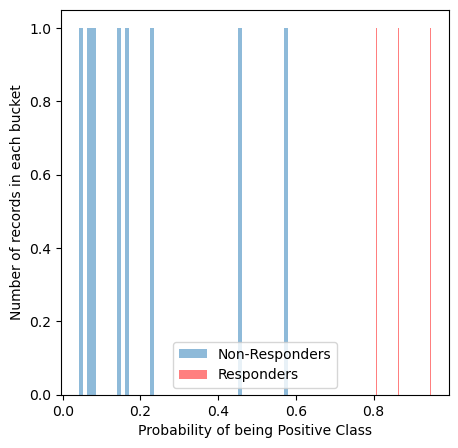

In [33]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [34]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.421446,-0.155943,-0.820807,-0.764873,0.176513,-0.592751,0.217048,-0.421514,-0.398037,0.679370,...,-0.334583,-1.112364,0.841049,-1.204004,-0.369824,0.356009,-0.669323,1.114645,NaN,NaN
1,-0.276533,0.572536,-0.474419,-0.160824,0.726806,-0.304058,-1.106525,-1.011080,-1.062693,1.195910,...,-1.073172,0.019150,-0.860808,-1.068167,-1.023607,-2.011757,-1.531648,0.751141,NaN,NaN
2,0.917049,0.895743,-1.111086,-0.418279,0.670938,-0.708936,0.749646,0.704073,0.669361,-0.581583,...,0.109263,-0.975546,-0.100293,-1.093242,-0.235740,-0.480951,-0.557013,-0.180528,NaN,NaN
3,-1.404404,-1.398709,0.840344,0.805608,1.267643,-0.486297,0.309795,1.693589,1.809365,-0.688164,...,-0.063484,-0.269385,0.365588,0.180347,-0.321133,-0.747372,0.579028,-0.752884,NaN,NaN
4,-1.428276,-0.030653,-0.487401,0.307332,-1.303769,-0.704605,-0.787556,-0.148086,-0.509767,-0.818812,...,-1.162260,0.264939,-1.561619,1.072908,-1.897890,-0.590766,-1.063269,-0.034932,NaN,NaN
5,-0.122632,-0.030653,-0.658222,-0.149505,0.047454,-0.376167,1.183834,0.809655,0.484157,1.631954,...,-0.354849,0.492494,0.097928,0.637338,-1.299829,1.089749,0.615303,-1.007477,0.041974,0.0
6,-0.028387,-1.600535,-0.274027,0.442857,-0.476422,-0.138457,-1.200257,-0.624682,-0.779818,0.094471,...,-0.526166,-0.860416,-0.339996,0.180957,0.165533,-0.772022,-0.394404,1.738498,0.161116,0.0
7,-1.993223,-0.030653,0.328400,0.027379,-0.028674,-0.239473,-0.672452,-1.200074,-1.390005,1.567773,...,-1.997326,-0.735551,-2.008697,0.757392,-1.504734,-1.184572,-0.980471,-1.347526,NaN,NaN
8,-0.830990,-0.429200,-0.831757,-1.207008,0.666399,-0.794150,0.111326,1.295991,1.658446,-0.293185,...,0.266737,-1.034167,-0.020598,-0.813857,-0.372621,0.084995,0.243565,0.066779,NaN,NaN
9,2.406220,-1.138422,-0.060254,0.598620,0.306704,-0.587151,0.235557,0.175742,0.240367,0.233553,...,0.107424,-1.045998,0.595314,-0.177065,0.421267,0.056379,0.238078,0.619778,NaN,NaN


In [35]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
13,-0.410634,0.288067,-0.553206,2.475739,0.002499,-0.371078,-0.961989,0.007428,-0.203719,0.121336,...,0.780801,0.941834,0.203433,-0.099921,1.316756,0.057736,0.406860,-0.845098,0.948277,1.0
19,1.502590,-1.718961,-1.208068,-0.870104,0.268140,-1.148039,0.193726,0.542698,0.748482,-1.229169,...,0.020257,-1.034559,-0.336676,-1.053117,-0.276233,-0.060669,-0.441173,0.772968,0.864928,1.0
44,0.003429,1.603478,-0.807481,0.750058,-0.105665,-0.058717,-0.619474,0.593179,-0.330089,-1.031988,...,-0.231104,4.038854,0.481596,-0.756903,0.492345,-0.692225,-0.534204,0.724033,0.806385,1.0


In [36]:
max(prediction3[y_test == 0])

0.57887226

In [37]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [38]:
cl = set(common_list)
cl

{13, 19, 44}

In [39]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
13,-0.410634,0.288067,-0.553206,2.475739,0.002499,-0.371078,-0.961989,0.007428,-0.203719,0.121336,...,0.780801,0.941834,0.203433,-0.099921,1.316756,0.057736,0.406860,-0.845098,0.508667,1.0
19,1.502590,-1.718961,-1.208068,-0.870104,0.268140,-1.148039,0.193726,0.542698,0.748482,-1.229169,...,0.020257,-1.034559,-0.336676,-1.053117,-0.276233,-0.060669,-0.441173,0.772968,0.642800,1.0
44,0.003429,1.603478,-0.807481,0.750058,-0.105665,-0.058717,-0.619474,0.593179,-0.330089,-1.031988,...,-0.231104,4.038854,0.481596,-0.756903,0.492345,-0.692225,-0.534204,0.724033,0.519067,1.0


In [40]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [41]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')